# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [22]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [23]:
df = pd.read_csv("bikes_rent.csv")
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

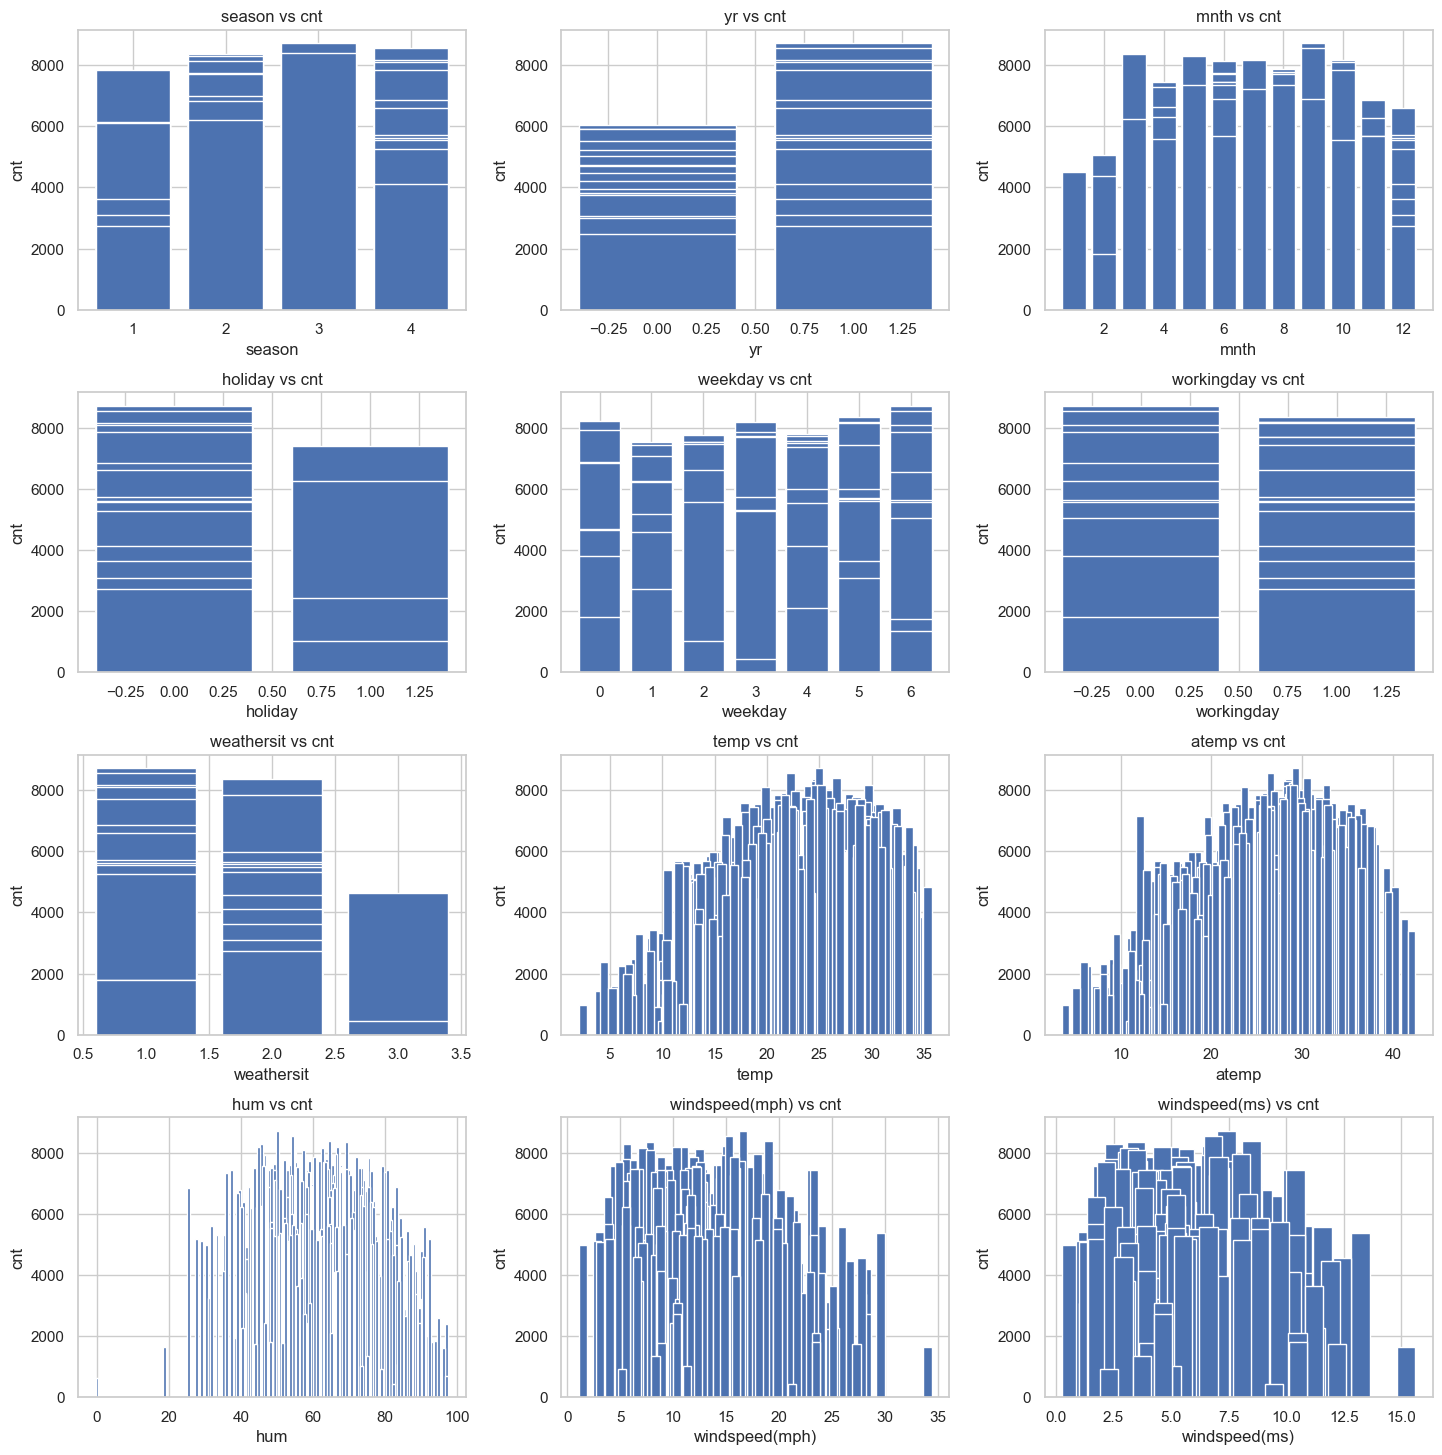

In [24]:
attributes = df.columns[:-1]
fig, axs = plt.subplots(4, 3, figsize=(15, 15))
fig.tight_layout(pad=3.0)

for i, attr in enumerate(attributes.tolist()):
    row = i // 3
    col = i % 3
    axs[row, col].bar(df[attr], df["cnt"])
    axs[row, col].set_title(f"{attr} vs cnt")
    axs[row, col].set_xlabel(attr)
    axs[row, col].set_ylabel("cnt")


plt.show()

__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца?
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно

__Ответы:__
1. Линейно-константный. Начиная с 3 месяця  показатель количества прокатов выростает, и стабильно держится в данном уровне до 10-го месяца, после идет плавное  понижения до наступления 2 месяца.

2. Season - лето, осень, количество прокатов возрастает. Weathersit - чем яснее день, тем количество прокатов больше, и наоборот как погода ухудшается - количество прокатов падает.

## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

In [25]:
correlation = df[["windspeed(ms)"]].corrwith(df["cnt"])
print(f"Correlation between windspeed(ms) and cnt =  {correlation}")
# correlation_ = df[["windspeed(ms)"]].corrwith(df["windspeed(mph)"])
# print(f"Correlation between windspeed(ms) and windspeed(mph) {correlation_}")
correlations = df[df.columns[:-2].tolist() + ["cnt"]].corr()
correlations

Correlation between windspeed(ms) and cnt =  windspeed(ms)   -0.234545
dtype: float64


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),cnt
season,1.000000,-0.001844,0.831440,-0.010537,-0.003080,0.012485,0.019211,0.334315,0.342876,0.205445,-0.229046,0.406100
yr,-0.001844,1.000000,-0.001792,0.007954,-0.005461,-0.002013,-0.048727,0.047604,0.046106,-0.110651,-0.011817,0.566710
mnth,0.831440,-0.001792,1.000000,0.019191,0.009509,-0.005901,0.043528,0.220205,0.227459,0.222204,-0.207502,0.279977
holiday,-0.010537,0.007954,0.019191,1.000000,-0.101960,-0.253023,-0.034627,-0.028556,-0.032507,-0.015937,0.006292,-0.068348
weekday,-0.003080,-0.005461,0.009509,-0.101960,1.000000,0.035790,0.031087,-0.000170,-0.007537,-0.052232,0.014282,0.067443
workingday,0.012485,-0.002013,-0.005901,-0.253023,0.035790,1.000000,0.061200,0.052660,0.052182,0.024327,-0.018796,0.061156
weathersit,0.019211,-0.048727,0.043528,-0.034627,0.031087,0.061200,1.000000,-0.120602,-0.121583,0.591045,0.039511,-0.297391
temp,0.334315,0.047604,0.220205,-0.028556,-0.000170,0.052660,-0.120602,1.000000,0.991702,0.126963,-0.157944,0.627494
atemp,0.342876,0.046106,0.227459,-0.032507,-0.007537,0.052182,-0.121583,0.991702,1.000000,0.139988,-0.183643,0.631066
hum,0.205445,-0.110651,0.222204,-0.015937,-0.052232,0.024327,0.591045,0.126963,0.139988,1.000000,-0.248489,-0.100659


В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

In [26]:
select_attributes = ["temp", "atemp", "hum", "windspeed(mph)", "windspeed(ms)", "cnt"]
correlation_attributes = df[select_attributes].corr()
correlation_attributes


,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

## Задание 4

Выведите средние признаков

In [27]:
attributes_mean = df[attributes].mean()
attributes_mean

season             2.496580
yr                 0.500684
mnth               6.519836
holiday            0.028728
weekday            2.997264
workingday         0.683995
weathersit         1.395349
temp              20.310776
atemp             23.717699
hum               62.789406
windspeed(mph)    12.762576
windspeed(ms)      5.705220
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [28]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [29]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [30]:
from sklearn.linear_model import LinearRegression

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.


In [31]:
regressor = LinearRegression().fit(X, y)
coef = regressor.coef_
for feature, weight in zip(df.columns, coef):
    print(f"{feature}: {weight}")

season: 570.869840420185
yr: 1021.9648369366325
mnth: -141.3057498128626
holiday: -86.7602382288565
weekday: 137.22990306303458
workingday: 56.39005586999093
weathersit: -330.2330450008552
temp: 367.4652763382111
atemp: 585.5643746373447
hum: -145.6036472997277
windspeed(mph): 12460406274500.414
windspeed(ms): -12460406274698.863


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

In [32]:
from sklearn import linear_model

clf = linear_model.Lasso()
clf.fit(X, y)
coef = clf.coef_
for feature, weight in zip(df.columns, coef):
    print(f"{feature}: {weight}")

season: 560.2416160308865
yr: 1019.4634940657198
mnth: -128.73062703678733
holiday: -86.15278133371098
weekday: 137.347893904963
workingday: 55.212370641356785
weathersit: -332.3698569623486
temp: 376.36323620969347
atemp: 576.5307935045563
hum: -144.12915500348578
windspeed(mph): -197.13968940248455
windspeed(ms): -2.805103823944435e-08


Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [33]:
clf = linear_model.Ridge()
clf.fit(X, y)
coef = clf.coef_
for feature, weight in zip(df.columns, coef):
    print(f"{feature}: {weight}")

season: 563.0645722520163
yr: 1018.948378787527
mnth: -131.87332028247576
holiday: -86.74609799709245
weekday: 138.0051111787192
workingday: 55.90311037506427
weathersit: -332.3497884990726
temp: 386.45788919191114
atemp: 566.3470470600643
hum: -145.07132729867305
windspeed(mph): -99.25944108182756
windspeed(ms): -99.25944115430536


### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [34]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(X, y)
    coefs_lasso.append(clf.coef_)
    clf = linear_model.Ridge(alpha=alpha)
    clf.fit(X, y)
    coefs_ridge.append(clf.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)
print(coefs_lasso)
print(coefs_ridge)

[[ 5.60241616e+02  1.01946349e+03 -1.28730627e+02 -8.61527813e+01
   1.37347894e+02  5.52123706e+01 -3.32369857e+02  3.76363236e+02
   5.76530794e+02 -1.44129155e+02 -1.97139689e+02 -2.80510382e-08]
 [ 4.10969632e+02  9.77019409e+02 -0.00000000e+00 -5.34489688e+01
   9.19434374e+01  1.75372118e+01 -3.18125568e+02  3.22829934e+02
   6.10031512e+02 -9.10689615e+01 -1.45066095e+02 -2.29895576e-08]
 [ 3.70077089e+02  9.35945490e+02  0.00000000e+00 -1.21619360e+01
   4.88886342e+01  0.00000000e+00 -3.08805664e+02  2.69417263e+02
   6.32502623e+02 -2.75042876e+01 -9.37749037e+01 -2.41636842e-08]
 [ 3.32835717e+02  8.91870058e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.79616688e+02  2.11052030e+02
   6.62920880e+02 -0.00000000e+00 -5.01551472e+01 -2.62778724e-08]
 [ 2.98134448e+02  8.45652857e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.35571345e+02  1.24144807e+02
   7.25379483e+02 -0.00000000e+00 -1.26461769e+01 -2.78799567e-08]
 [ 2.

Проанализируйте динамику весов при увеличении параметра регуляризации:

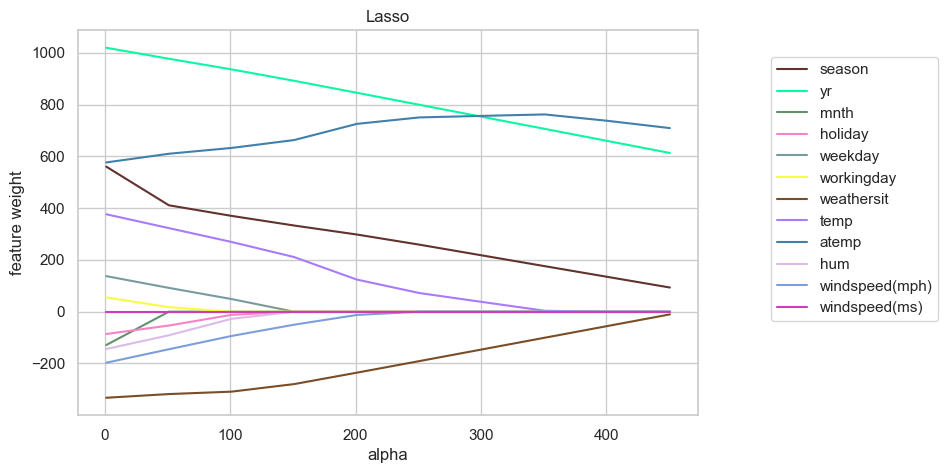

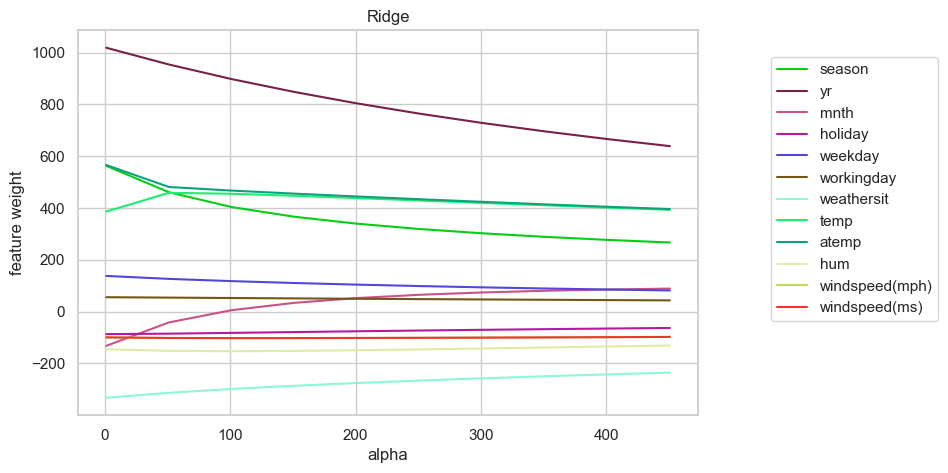

In [35]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
1. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении `alpha > 0`? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$.
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?

__Ответы__

1. Lasso агрессивнее уменьшает вес.
2. Если сделать apha очень большим то Lasso в итоге рано или поздно обнулит все признаки. Я думаю потому что Lasso более сильно штрафует веса признаков , и с увеличением alpha штраф увеличивается сильнее.
3. Да `Lasso`  исключает один из признаков `windspeed` при любом значении `alpha > 0`.   A Ridge  нет.
4. Ridge больше подойдет для отбора неинформативных признаков

### Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ часте, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

In [36]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

Alpha = 6
season: 532.0189828413535
yr: 1015.0602226430599
mnth: -100.03952614356623
holiday: -83.29395987529915
weekday: 132.50446549095793
workingday: 51.557085614073834
weathersit: -330.5598567399815
temp: 370.6798550300334
atemp: 581.3969310654986
hum: -140.00740550068872
windspeed(mph): -191.7714084713481
windspeed(ms): -2.6856977917781423e-08


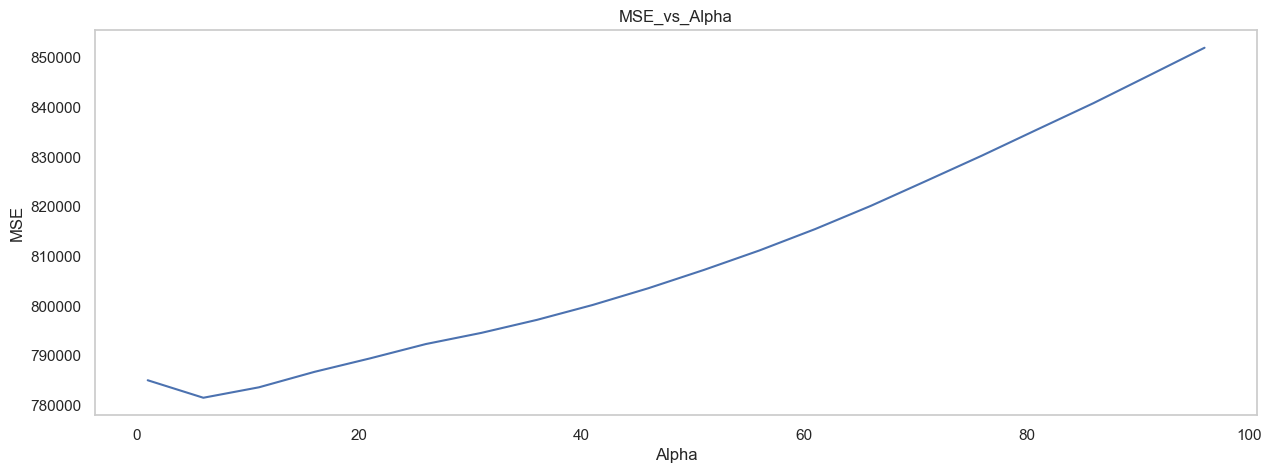

In [37]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=3).fit(X, y)
avg_mse = np.mean(regressor.mse_path_, axis=1)
data = list(zip(regressor.alphas_, avg_mse))

print(f"Alpha = {regressor.alpha_}")
coef = regressor.coef_

for feature, weight in zip(df.columns, coef):
    print(f"{feature}: {weight}")

create_plot(data, "MSE_vs_Alpha", "Alpha", "MSE")

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


Разбиение 1: Alpha = 6
Разбиение 2: Alpha = 1
Разбиение 3: Alpha = 51


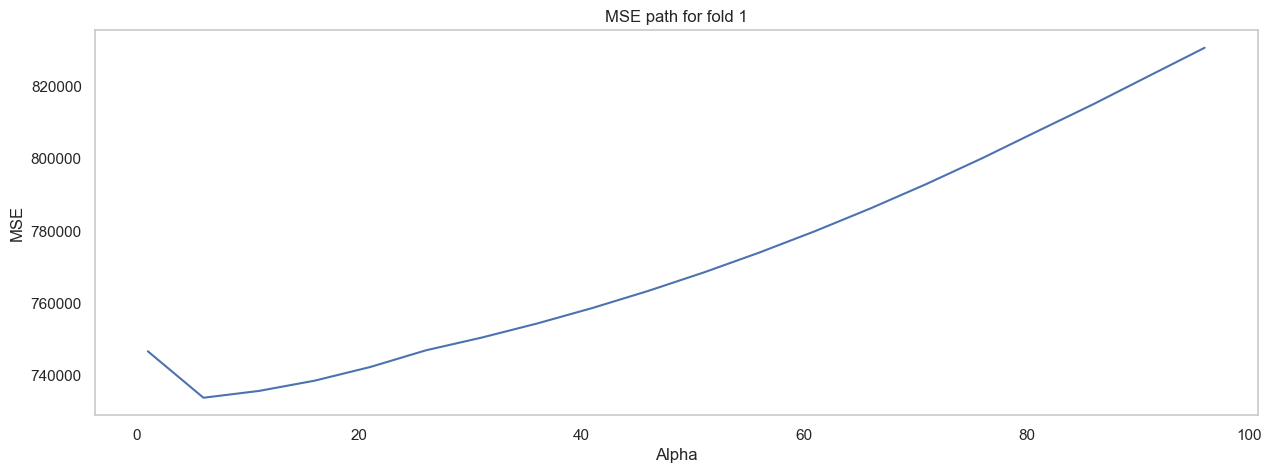

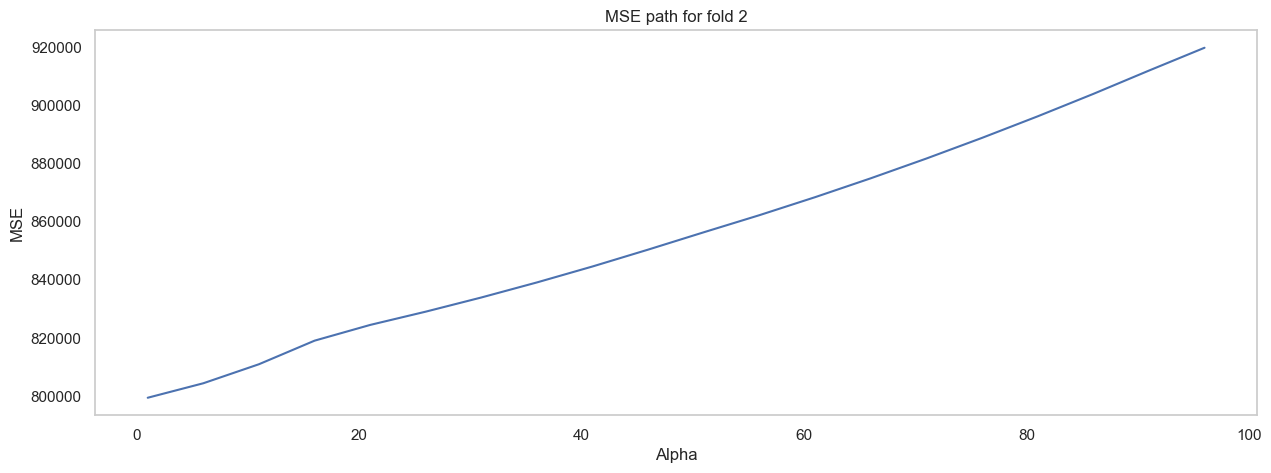

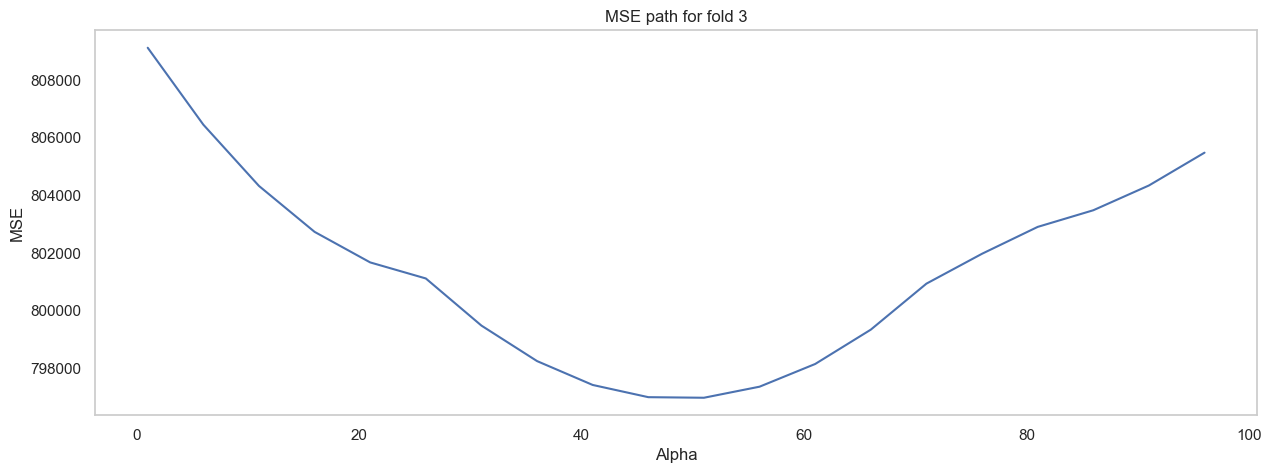

In [38]:
min_indexies = np.argmin(regressor.mse_path_, axis=0)
alphas_min_mse = regressor.alphas_[min_indexies]

for i, alpha in enumerate(alphas_min_mse):
    print(f"Разбиение {i+1}: Alpha = {alpha}")

for i in range(regressor.mse_path_.shape[1]):
    data = list(zip(regressor.alphas_, regressor.mse_path_[:, i]))
    create_plot(data, f"MSE path for fold {i+1}", "Alpha", "MSE")


На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 

__Ответ:__
Зависимость видна. Но прямо не скажеш что зависимость зависит от увеличения значения признаков, не логично. Тут больше есть зависимость от характера , качества этих признаков. К прмеру чем признак более качествен (благоприятен) тем количество аренды велосипедов больше.

In [39]:
coef_df = pd.DataFrame({"feature": df.columns[:-1], "coefficient": coef})
sorted_coef_df = coef_df.sort_values(by="coefficient", ascending=False)
sorted_coef_df.head(4)

,feature,coefficient
1,yr,1015.060223
8,atemp,581.396931
0,season,532.018983
7,temp,370.679855


#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

__Ответ:__

Да зависимость видна. Вот ту да логично  и на графиках подтверждается, чем больше значение признака, тем  количество аренды велосипедов  меньше.

In [40]:
sorted_coef_df.tail(3)

,feature,coefficient
9,hum,-140.007406
10,windspeed(mph),-191.771408
6,weathersit,-330.559857


#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

__Ответ:__
Я думаю что модель  исключила windspeed(ms)  потому что этот признак практически не имеют  веса влияния на прогноз. А вот по графикам видно что есть зависимость от этого параметра, но это и логично потому как  по сути это  есть дубирующие даннные windspeed(mph) про которые мы говорили выше. 

In [41]:
sorted_coef_df[sorted_coef_df["coefficient"].abs() < 1e-3]

,feature,coefficient
11,windspeed(ms),-2.685698e-08


### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.